In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from catboost import CatBoostClassifier

In [3]:
df = pd.read_csv('HR.csv')
df.describe() #основные статистики для кол переменных

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [4]:
df.mode().iloc[0] #моды

satisfaction_level         0.1
last_evaluation           0.55
number_project             4.0
average_montly_hours       135
time_spend_company         3.0
Work_accident              0.0
left                       0.0
promotion_last_5years      0.0
department               sales
salary                     low
Name: 0, dtype: object

C:\Users\serga\AppData\Local\Temp\ipykernel_20640\1240262794.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


<Axes: >

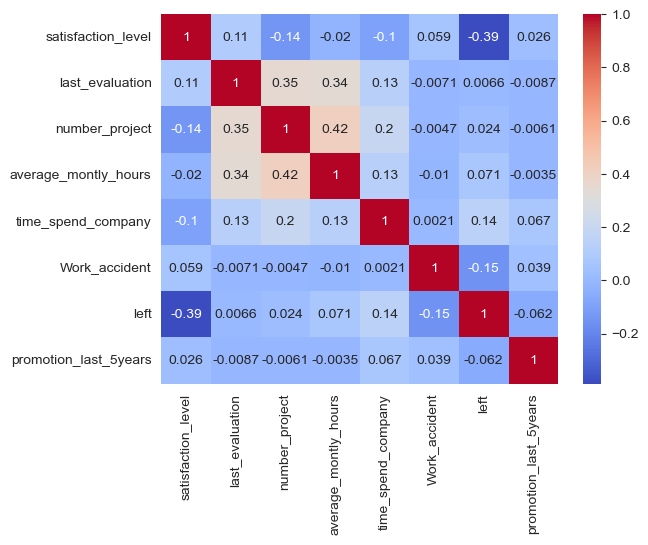

In [5]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [6]:
cm = correlation_matrix.abs()
cm = cm.unstack().sort_values(kind="quicksort", ascending=False)
cm = cm[cm != 1]

least_correlated = cm[-2:]
most_correlated = cm[:2]

In [7]:
most_correlated

number_project        average_montly_hours    0.417211
average_montly_hours  number_project          0.417211
dtype: float64

In [8]:
least_correlated

time_spend_company  Work_accident         0.00212
Work_accident       time_spend_company    0.00212
dtype: float64

In [9]:
df['department'].value_counts() # считаем, сколько сотрудников работает в каждом департаменте.

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: department, dtype: int64

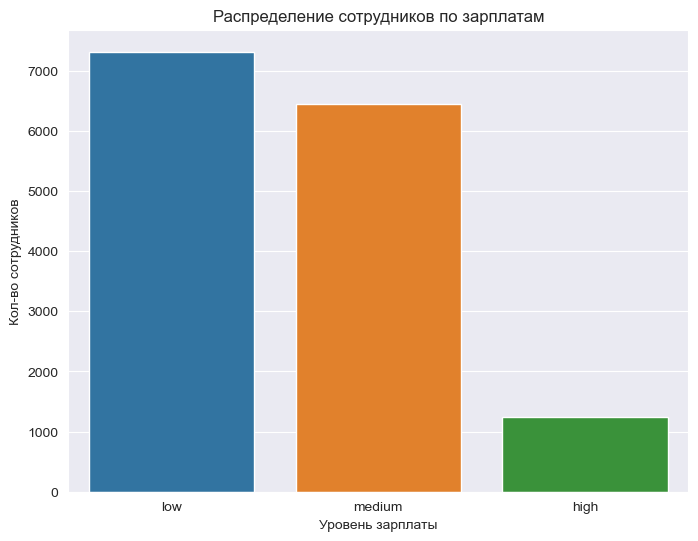

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='salary', order=['low', 'medium', 'high'])
plt.title('Распределение сотрудников по зарплатам')
plt.xlabel('Уровень зарплаты')
plt.ylabel('Кол-во сотрудников')
plt.show()


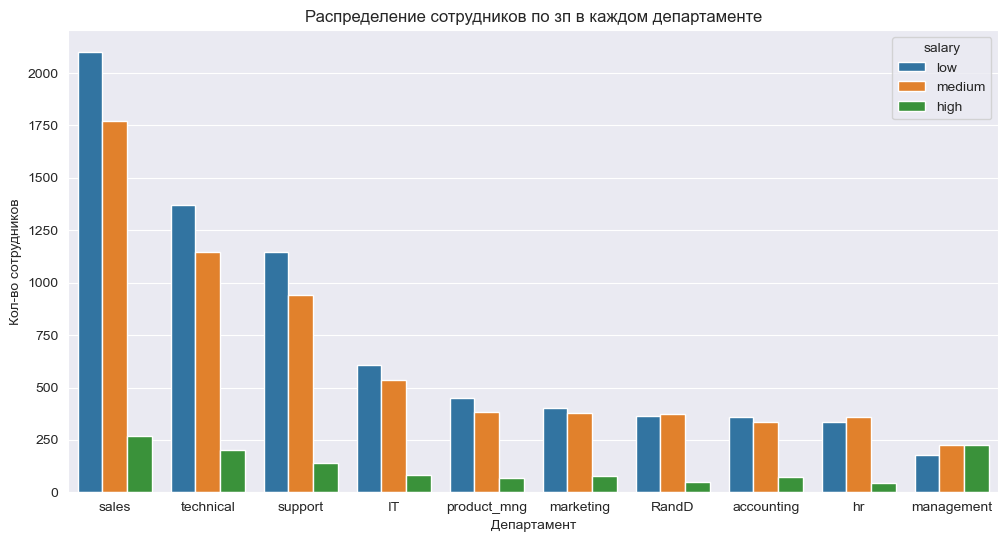

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='department', hue='salary', order=df['department'].value_counts().index)
plt.title('Распределение сотрудников по зп в каждом департаменте')
plt.xlabel('Департамент')
plt.ylabel('Кол-во сотрудников')
plt.xticks(rotation=0)
plt.show()

In [12]:
high_sal= df[df['salary'] == 'high']['average_montly_hours']
low_sal = df[df['salary'] == 'low']['average_montly_hours']

<Axes: xlabel='average_montly_hours', ylabel='Count'>

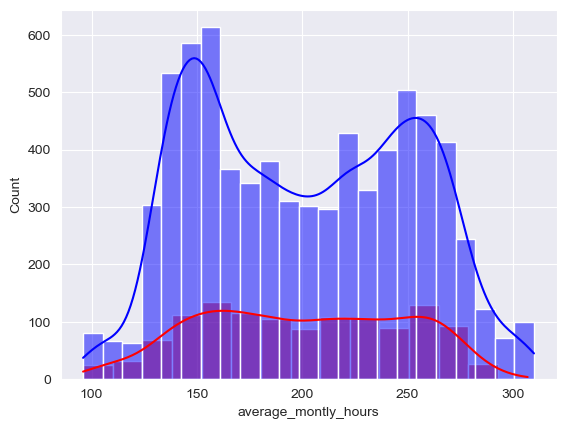

In [13]:
sns.histplot(high_sal, color="red", label="High Salary", kde=True)
sns.histplot(low_sal, color="blue", label="Low Salary", kde=True)

<Axes: >

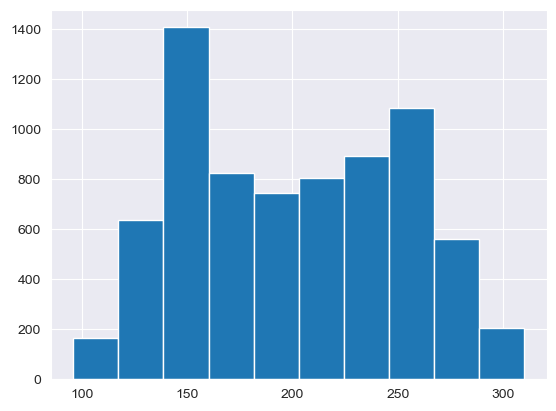

In [14]:
low_sal.hist()

In [16]:
alpha = 0.05 # установим уровень значимости 5%

mw_stat, mw_p_value = mannwhitneyu(high_sal, low_sal)
'''
Нулевая гипотеза H0: Среднее кол-во часов на работе одинаково для сотрудников с высокими и низкими зарплатами.
Альтернативная гипотеза H1: Среднее кол-во часов на работе различается для сотрудников с высокими и низкими зарплатами.
'''
if mw_p_value < alpha:
    print(f"Отвергаем нулевую гипотезу, среднее кол-во часов на работе различается, p-value: {mw_p_value.round(2)}")
else:
    print(f"Не отвергаем нулевую гипотезу, среднее количество часов на работе одинаково, p-value: {mw_p_value.round(2)}")
print("Среднее кол-во часов на работе сотрудников с высокой зарплатой:", high_sal.mean().round().astype(int))
print("Среднее кол-во часов на работе сотрудников с низкой зарплатой:", low_sal.mean().round().astype(int))

Не отвергаем нулевую гипотезу, среднее количество часов на работе одинаково, p-value: 0.82
Среднее кол-во часов на работе сотрудников с высокой зарплатой: 200
Среднее кол-во часов на работе сотрудников с низкой зарплатой: 201


In [17]:
left_df = df[df['left'] == 1]
stayed_df = df[df['left'] == 0]
results = pd.DataFrame(index=["Уволившиеся", "Не уволившиеся"],
                       columns=["Доля с повышением за последние 5 лет", 
                                "Средняя степень удовлетворенности", 
                                "Среднее количество проектов"])

results.loc["Уволившиеся", "Доля с повышением за последние 5 лет"] = left_df['promotion_last_5years'].mean()
results.loc["Уволившиеся", "Средняя степень удовлетворенности"] = left_df['satisfaction_level'].mean()
results.loc["Уволившиеся", "Среднее количество проектов"] = left_df['number_project'].mean()
results.loc["Не уволившиеся", "Доля с повышением за последние 5 лет"] = stayed_df['promotion_last_5years'].mean()
results.loc["Не уволившиеся", "Средняя степень удовлетворенности"] = stayed_df['satisfaction_level'].mean()
results.loc["Не уволившиеся", "Среднее количество проектов"] = stayed_df['number_project'].mean()

results

,Доля с повышением за последние 5 лет,Средняя степень удовлетворенности,Среднее количество проектов
Уволившиеся,0.005321,0.440098,3.855503
Не уволившиеся,0.026251,0.66681,3.786664


In [18]:
X = df.drop(['left', 'department', 'salary'], axis=1)
y = df['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)

accuracy_score(y_test, y_pred)

0.7633333333333333

In [19]:
confusion_matrix(y_test, y_pred)

array([[3168,  294],
       [ 771,  267]], dtype=int64)

In [20]:
recall_score(y_test, y_pred)

0.25722543352601157

In [21]:
categorical_features = ['department', 'salary']

X = df.drop('left', axis=1)
y = df['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

cbc = CatBoostClassifier(
    cat_features=categorical_features, 
    learning_rate=0.05, 
    depth=8, 
    iterations=5000, 
    l2_leaf_reg=3,
    border_count=32,
    verbose=False
)

cbc.fit(X_train, y_train)

y_pred = cbc.predict(X_test)

accuracy_score(y_test, y_pred)

C:\Users\serga\anaconda3\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0.9866666666666667

In [22]:
confusion_matrix(y_test, y_pred)

array([[3437,   25],
       [  35, 1003]], dtype=int64)

In [23]:
recall_score(y_test, y_pred)

0.9662813102119461